In [ ]:
!pip install -q pdfplumber pymupdf pillow chromadb sentence-transformers transformers playwright requests nest_asyncio

# Setup Playwright
!playwright install chromium

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 5.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 37.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 26.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.5/19.5 MB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.2/284.2 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 51.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.6/101.6 kB 6.9 MB/s eta 0:0

In [ ]:
import textwrap
import pdfplumber
import fitz
import chromadb
import requests
import io
import asyncio
import nest_asyncio
from PIL import Image
from sentence_transformers import SentenceTransformer
from playwright.async_api import async_playwright
from transformers import pipeline
from IPython.display import display, Markdown
from google.colab import files

In [ ]:
# Initialize async environment
nest_asyncio.apply()

In [ ]:
# Initialize models
text_encoder = SentenceTransformer('all-MiniLM-L6-v2')
llm = pipeline("text-generation", model="gpt2", max_length=1024)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cpu


In [ ]:
async def web_screenshot(url):
    """Async webpage screenshot capture"""
    try:
        async with async_playwright() as p:
            browser = await p.chromium.launch(headless=True)
            page = await browser.new_page()
            await page.goto(url, timeout=30000)
            screenshot = await page.screenshot()
            await browser.close()
        return screenshot
    except Exception as e:
        print(f"Web capture error: {e}")
        return None

In [ ]:
def preprocess_pdf(pdf_path):
    """Process PDF with paragraph-level chunking"""
    client = chromadb.PersistentClient(path="./chroma_db")
    collection = client.get_or_create_collection("visual_rag")

    with pdfplumber.open(pdf_path) as pdf:
        for page_num, page in enumerate(pdf.pages):
            text = page.extract_text()
            if text:
                paragraphs = [p.strip() for p in text.split('\n') if p.strip()]

                for para_num, para in enumerate(paragraphs):
                    words = page.extract_words()
                    para_words = [w for w in words if w['text'] in para]

                    if para_words:
                        x0 = min(w['x0'] for w in para_words)
                        top = min(w['top'] for w in para_words)
                        x1 = max(w['x1'] for w in para_words)
                        bottom = max(w['bottom'] for w in para_words)
                        bbox = (x0, top, x1, bottom)

                        collection.add(
                            ids=f"p{page_num}_para{para_num}",
                            documents=para,
                            metadatas={
                                "page": page_num,
                                "bbox": str(bbox),
                                "type": "text"
                            }
                        )
    print(f"✅ PDF processed: {pdf_path}")

In [ ]:
class VisualRAG:
    def __init__(self, pdf_path):
        self.pdf_path = pdf_path
        self.client = chromadb.PersistentClient(path="./chroma_db")
        self.collection = self.client.get_collection("visual_rag")

    def _get_para_screenshot(self, page_num, bbox_str):
        """Generate paragraph screenshot from PDF"""
        doc = fitz.open(self.pdf_path)
        page = doc.load_page(page_num)
        bbox = tuple(map(float, bbox_str.strip('()').split(',')))
        return page.get_pixmap(clip=bbox).tobytes()

    def _truncate_context(self, text, max_tokens=900):
        """Ensure context fits model limits"""
        return ' '.join(text.split()[:max_tokens])

    async def query(self, question, api_key):
        """Full query pipeline with async web handling"""
        # PDF Retrieval
        results = self.collection.query(
            query_texts=[question],
            n_results=3,
            include=["documents", "metadatas"]
        )

        # Process PDF sources
        pdf_sources = []
        pdf_context = []
        for doc, meta in zip(results["documents"][0], results["metadatas"][0]):
            truncated = self._truncate_context(doc)
            pdf_context.append(f"[PDF] {truncated}")
            pdf_sources.append({
                "type": "pdf",
                "page": meta["page"],
                "text": doc,
                "screenshot": self._get_para_screenshot(meta["page"], meta["bbox"])
            })

        # Web Search
        web_sources = []
        web_context = []
        try:
            web_resp = requests.get(
                "https://serpapi.com/search",
                params={
                    "q": question,
                    "api_key": api_key,
                    "engine": "google",
                    "num": 2
                },
                timeout=15
            )

            if web_resp.status_code == 200:
                web_results = web_resp.json().get("organic_results", [])[:2]
                for result in web_results:
                    if 'snippet' in result:
                        web_context.append(f"[Web] {self._truncate_context(result['snippet'])}")
                        web_sources.append({
                            "type": "web",
                            "url": result['link'],
                            "snippet": result['snippet']
                        })
        except Exception as e:
            print(f"Web search error: {e}")

        # Generate answer
        context = "\n".join(pdf_context + web_context)
        prompt = f"""Answer the question using these sources. Cite as [PDF] or [Web].
        Question: {question}
        Context: {context}
        Answer:"""

        answer = llm(prompt, max_length=1024, num_return_sequences=1)[0]['generated_text']
        answer = answer.split("Answer:")[-1].strip()

        # Capture web screenshots async
        for source in web_sources:
            source['screenshot'] = await web_screenshot(source['url'])

        return answer, pdf_sources + web_sources

In [ ]:
async def main():
    # Upload PDF
    print("📤 Upload PDF file:")
    uploaded = files.upload()
    pdf_name = next(iter(uploaded))
    preprocess_pdf(pdf_name)

    # Initialize RAG
    rag = VisualRAG(pdf_name)
    api_key = input("🔑 Enter SerpAPI key: ")

    # Query loop
    while True:
        print("\n" + "="*50)
        question = input("❓ Ask a question (q to quit): ")
        if question.lower() == 'q':
            break

        answer, sources = await rag.query(question, api_key)

        # Display results
        print("\n💡 Answer:")
        display(Markdown(answer))

        print("\n🔍 Sources:")
        for i, source in enumerate(sources, 1):
            print(f"\n📌 [Source {i}] {source['type'].upper()}")
            if source["type"] == "pdf":
                print(f"Page {source['page']+1}:")
                display(Image.open(io.BytesIO(source['screenshot'])))
                print(textwrap.shorten(source['text'], width=200))
            else:
                print(f"URL: {source['url']}")
                if 'snippet' in source:
                    print(textwrap.shorten(source['snippet'], width=200))
                if source.get('screenshot'):
                    display(Image.open(io.BytesIO(source['screenshot'])))

📤 Upload PDF file:


Saving The primary total knee arthroplasty_ a global analysis.pdf to The primary total knee arthroplasty_ a global analysis.pdf


/root/.cache/chroma/onnx_models/all-MiniLM-L6-v2/onnx.tar.gz: 100%|██████████| 79.3M/79.3M [00:03<00:00, 25.1MiB/s]


✅ PDF processed: The primary total knee arthroplasty_ a global analysis.pdf



Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



💡 Answer:


what is total knee arthroplasty
[PDF] Keywords: Knee arthroplasty, Knee arthroplasty, Knee arthroplasty, Knee arthroplasty, Knee arthroplasty, Knee arthroplasty, Knee arthroplasty, Knee arthroplasty, Knee arthroplasty, Knee arthroplasty, Knee arthroplasty, Knee arthroplasty, Knee arthroplasty, Knee arthroplasty, Knee arthroplasty, Knee arthroplasty, Knee arthroplasty, Knee arthroplasty, Knee arthroplasty, Knee arthroplasty, Knee arthroplasty, Knee arthroplasty, Knee arthroplasty, Knee arthroplasty, Knee arthroplasty, Knee arthroplasty, Knee arthroplasty, Knee arthroplasty, Knee arthroplasty, Knee arthroplasty, Knee arthroplasty, Knee arthroplasty, Knee arthroplasty, Knee arthroplasty, Knee arthroplasty, Knee arthroplasty, Knee arthroplasty, Knee arthroplasty, Knee arthroplasty, Knee arthroplasty, Knee arthroplasty, Knee arthroplasty, Knee arthroplasty, Knee arthroplasty, Knee arthroplasty, Knee arthroplasty, Knee arthroplasty, Knee arthroplasty, Knee arthroplasty, Knee arthroplasty, Knee arthroplasty, Knee arthroplasty, Knee arthroplasty, Knee arthroplasty, Knee arthroplasty, Knee arthroplasty, Knee arthroplasty, Knee arthroplasty, Knee arthroplasty, Knee arthroplasty, Knee arthroplasty, Knee arthroplasty, Knee arthroplasty, Knee arthroplasty, Knee arthroplasty, Knee arthroplasty, Knee arthroplasty, Knee arthroplasty, Knee arthroplasty, Knee arthroplasty, Knee arthroplasty, Knee arthroplasty, Knee arthroplasty, Knee arthroplasty, Knee arthroplasty, Knee arthroplasty, Knee arthroplasty, Knee arthroplasty, Knee arthroplasty, Knee arthroplasty, Knee arthroplasty, Knee arthroplasty, Knee arthroplasty, Knee arthroplasty, Knee arthroplasty, Knee arthroplasty, Knee arthroplasty, Knee arthroplasty, Knee arthroplasty, Knee arthroplasty, Knee arthroplasty, Knee arthroplasty, Knee arthroplasty, Knee arthroplasty, Knee arthroplasty, Knee arthroplasty, Knee arthroplasty, Knee arthroplasty, Knee arthroplasty, Knee arthroplasty, Knee arthroplasty, Knee arthroplasty, Knee arthroplasty, Knee arthroplasty, Knee arthroplasty, Knee arthroplasty, Knee arthroplasty, Knee arthroplasty, Knee arthroplasty, Knee arthroplasty, Knee arthroplasty, Knee arthroplasty, Knee arthroplasty, Knee arthroplasty, Knee arthroplasty, Knee arthroplasty, Knee arthroplasty, Knee arthroplasty, K


🔍 Sources:

📌 [Source 1] PDF
Page 1:


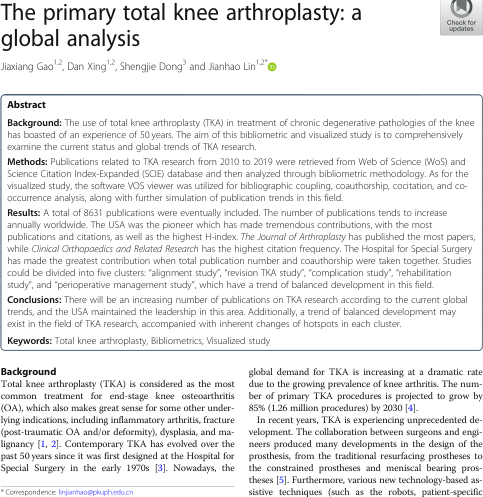

The primary total knee arthroplasty: a

📌 [Source 2] PDF
Page 1:


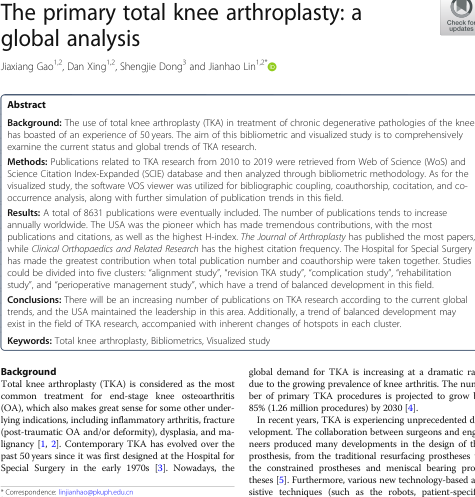

Keywords: Total knee arthroplasty, Bibliometrics, Visualized study

📌 [Source 3] PDF
Page 1:


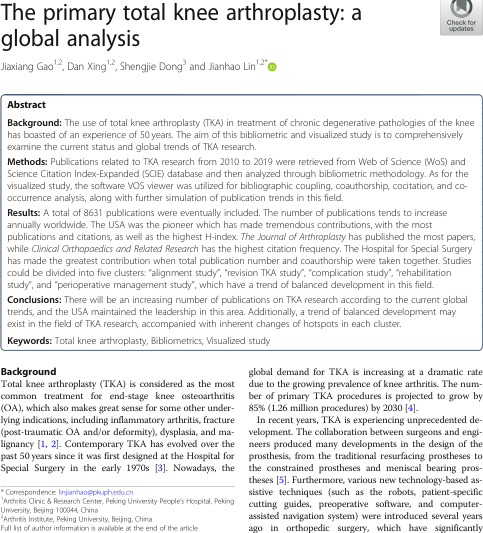

Background: The use oftotal knee arthroplasty(TKA) intreatment of chronic degenerative pathologiesof the knee

📌 [Source 4] WEB
URL: https://orthoinfo.aaos.org/en/treatment/total-knee-replacement/
Joint replacement surgery is a safe and effective procedure to relieve pain, correct leg deformity, and help you resume normal activities.


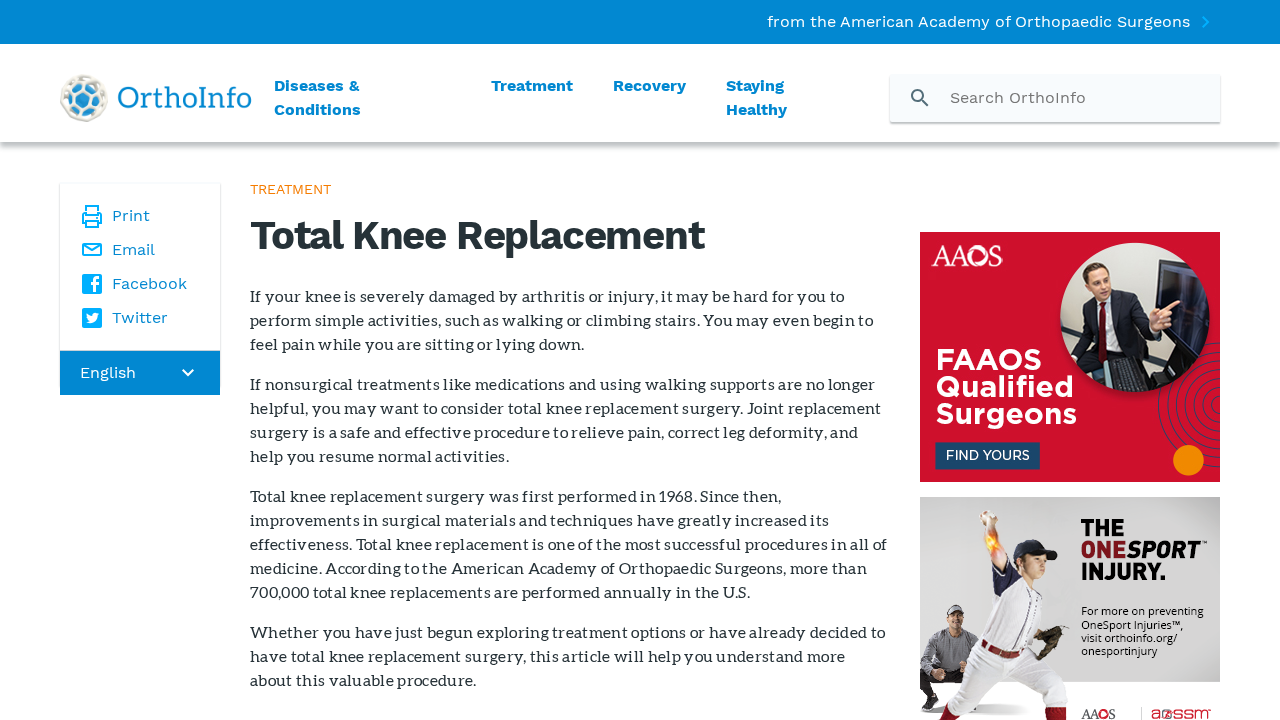


📌 [Source 5] WEB
URL: https://www.hopkinsmedicine.org/health/treatment-tests-and-therapies/knee-replacement-surgery-procedure
Knee replacement, also called knee arthroplasty or total knee replacement, is a surgical procedure to resurface a knee damaged by arthritis.


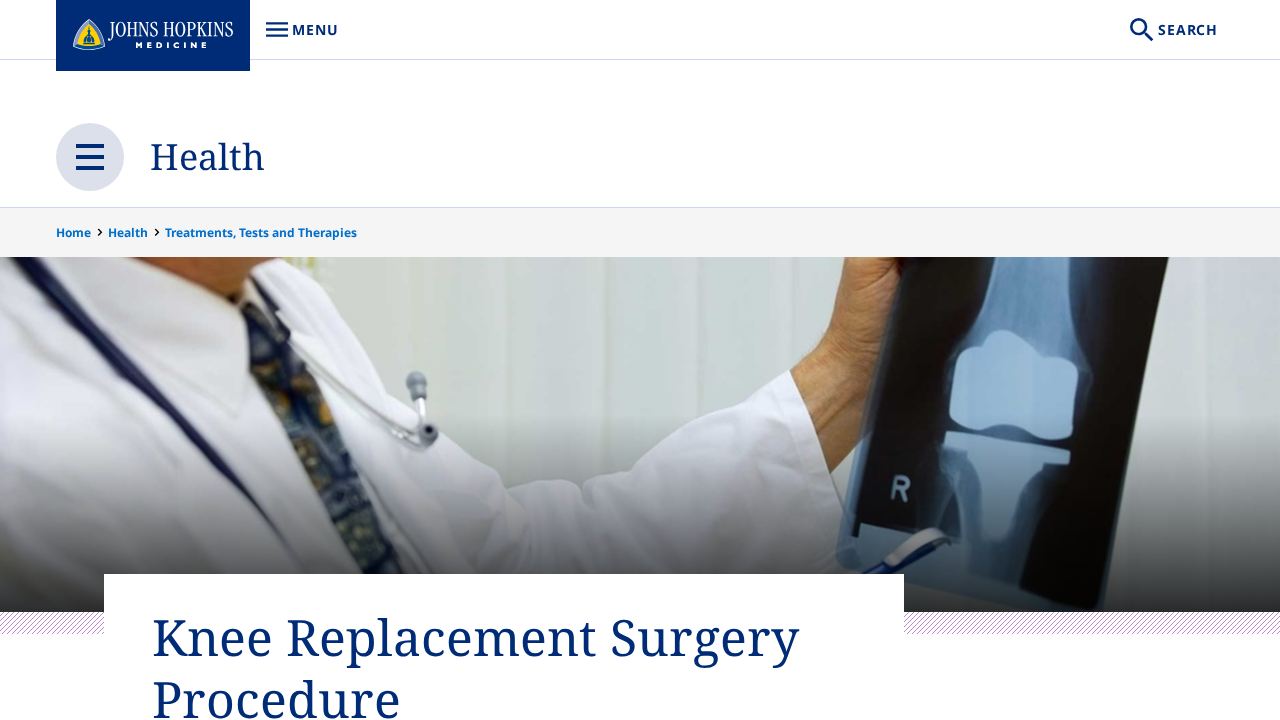

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



💡 Answer:


knee replacement surgery is a procedure to remove part of a knee if it is still standing and if there is no other alternative.
[PDF] The procedure is performed after a thorough examination of the knee to determine if there is any abnormal bone or cartilage in the knee.
[Web] Does this surgery take two to three days to complete? · Does it take a minimum of two to three weeks to complete?
[PDF] Does the procedure require a physician to perform the surgery? · Does the procedure take place after surgery?
[Web] Does the procedure require a surgeon to perform the surgery? · Does it require a certified specialist? · Does it require follow-up?
[Web] Does this procedure require a doctor to perform the procedure? · Does it require follow-up?
[Web] Does this procedure require a certified specialist? · Does it require follow-up?
[Web] Does this procedure require a doctor to perform the procedure? · Does it require follow-up?
[Web] Does this procedure require a doctor to perform the surgery? · Does it require follow-up?
[Web] Does this procedure require a doctor to perform the surgery? · Does it require follow-up?
[Web] Does this procedure require a doctor to perform the surgery? · Does it require follow-up?
[Web] Does this procedure require a doctor to perform the surgery? · Does it require follow-up?
[Web] Does this procedure require a doctor to perform the surgery? · Does it require follow-up?
[Web] Does this procedure require a doctor to perform the surgery? · Does it require follow-up?
[Web] Does this procedure require a doctor to perform the surgery? · Does it require follow-up?
[Web] Does this procedure require a doctor to perform the surgery? · Does it require follow-up?
[Web] Does this procedure require a doctor to perform the surgery? I want to know what is the exact procedure that they are performing. · Who is performing this procedure? · Who is the person who performs it? · Is there a physical therapist that will do this surgery? · Can a person be involved in the procedure?
[Web] Does this procedure require a physician? · Do they have a referral procedure? · Can I get a referral to perform the procedure? · Is there a referral procedure available?
[Web] Does this procedure require a physician? · Do they have a referral procedure? · Is there a referral procedure available?
[Web] Does this procedure require a physician? · Do they have a referral procedure? · Is there a referral procedure available?
[Web] Does this procedure require a physician? · Do they have a referral procedure? · Is there a referral procedure available?
[Web] Does this procedure require a physician? · Do they have a referral procedure? · Is there a referral procedure available?
[Web] Does this procedure require a physician? · Does they have a referral procedure? · Is there a referral procedure available? I want to know what is the exact procedure that they are performing. · Who is performing this procedure? · Do they have a referral procedure? · Is there a physical therapist that will do this surgery? · Can a person be involved in the procedure?
[Web] Does this procedure require a physician? · Do they have a referral procedure? · Is there a referral procedure available? I want to know what is the exact procedure that they are performing. · Who is performing this procedure? · Do they have a referral procedure? · Is there a referral procedure available?
[Web] Does this procedure require a physician? · Do they have a referral procedure? · Is there a referral procedure available? I want to know what is the exact procedure that they are performing. · Who is performing this procedure? · Do they have a referral procedure? · Is there a referral procedure available?
[Web] Does this procedure require a physician? · Do they have a referral procedure? · Is there a referral procedure available? I want to know what is the exact procedure that they are performing


🔍 Sources:

📌 [Source 1] PDF
Page 1:


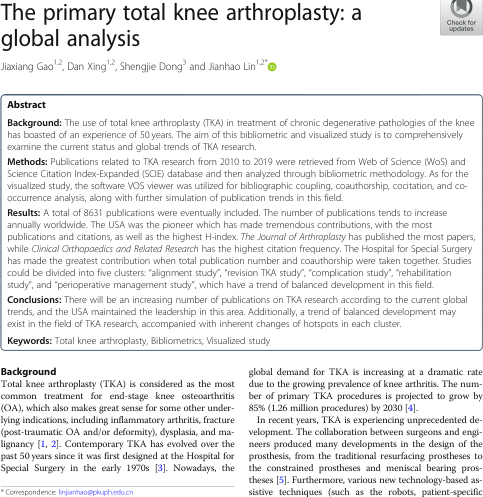

The primary total knee arthroplasty: a

📌 [Source 2] PDF
Page 3:


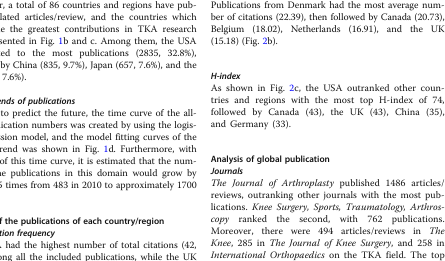

lications. Knee Surgery, Sports, Traumatology, Arthros-

📌 [Source 3] PDF
Page 4:


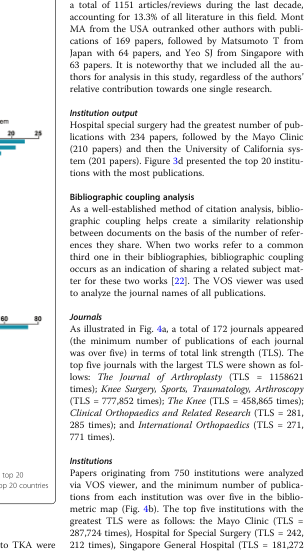

times); Knee Surgery, Sports, Traumatology, Arthroscopy

📌 [Source 4] WEB
URL: https://www.hopkinsmedicine.org/health/treatment-tests-and-therapies/knee-replacement-surgery-procedure
Knee replacement, also called knee arthroplasty or total knee replacement, is a surgical procedure to resurface a knee damaged by arthritis.


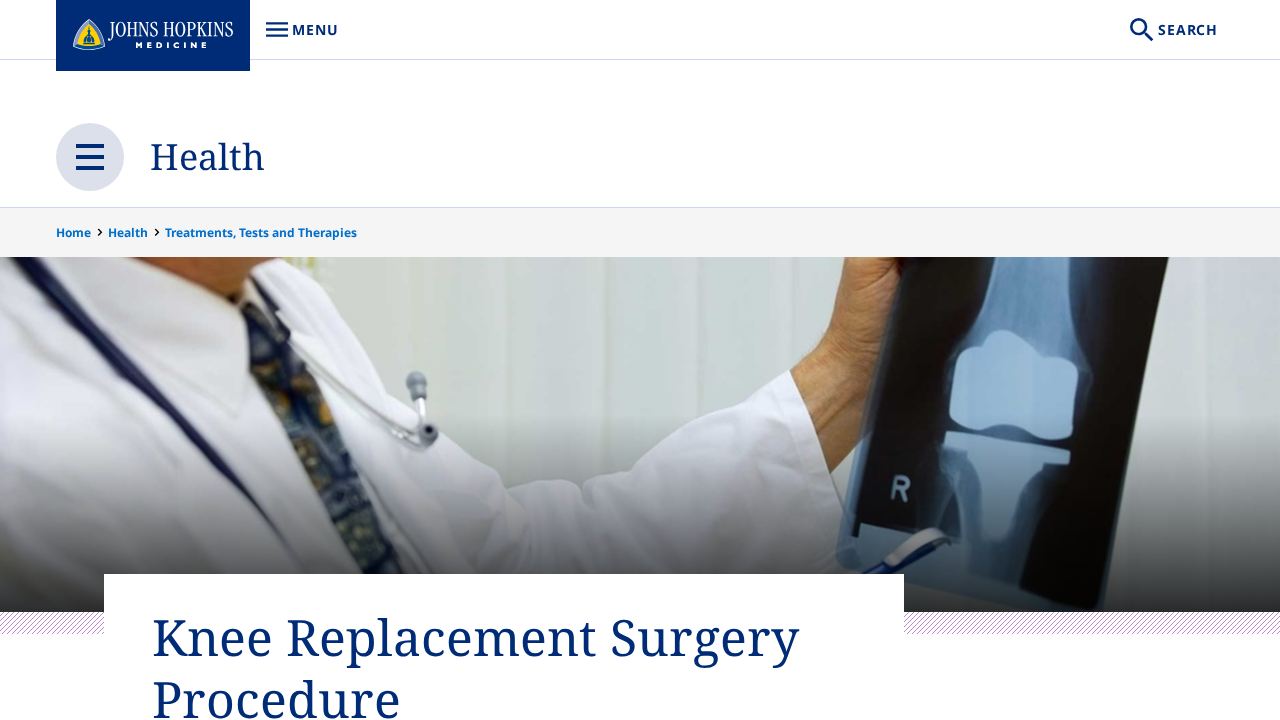


📌 [Source 5] WEB
URL: https://www.mayoclinic.org/tests-procedures/knee-replacement/about/pac-20385276
Makes an incision over the knee. · Removes diseased and damaged bone and cartilage, leaving healthy bone intact. · Implants the replacement parts ...


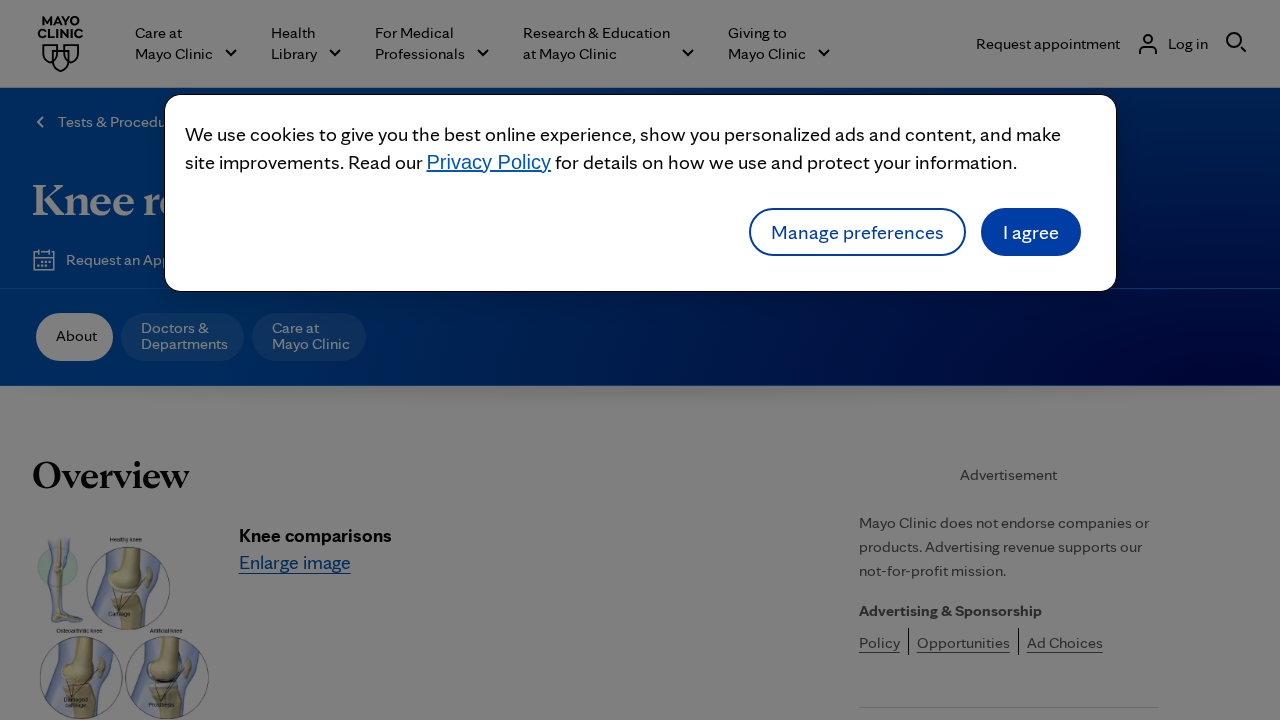

In [ ]:
# %% [code]
if __name__ == "__main__":
    asyncio.run(main())